In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# create stopword list
stop_words = stopwords.words('english')

# some texts need to remove all special characters, just leave english alphabets and space
filter_words = "qwertyuioplkjhgfdsazxcvbnm "

# remove stop words
def removeStopWords(file):
    file = file.replace('<b>', ' ')
    file = file.replace('<br />', ' ')
    file = file.replace('</b>', ' ')
    file = file.lower()
    file = ''.join(list(filter(lambda ch: ch in filter_words, file)))
    word_tokens = word_tokenize(file) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    file = " ".join(filtered_sentence)
    return file

# using CountVectorizer to extract text features
def extractTextFeature(file):
    # remove stop words
    for i in range(len(file)):
        file[i] = removeStopWords(file[i])
    # remove some rare words, might be wrong typing
    sentence_list =[]
    for txt in file:
        sentence_list += nltk.tokenize.word_tokenize(txt)
    word_dict = Counter(sentence_list)
    # create low frequency lib
    low_frequency_words = []
    low_frequency_words += ([k for (k,v) in  word_dict.items() if v <3])
    low_frequency_words += stop_words
    vectorizer = CountVectorizer(stop_words = low_frequency_words)  
    return vectorizer.fit_transform(file).toarray()

In [60]:
listings = pd.read_csv("listings.csv")
# listings.info()
# listings.head()

In [61]:
# Drop some features we don't need, such as website
listings = listings.drop(['listing_url'], axis=1)
listings = listings.drop(['scrape_id'], axis=1)
listings = listings.drop(['last_scraped'], axis=1)
listings = listings.drop(['source'], axis=1)
listings = listings.drop(['name'], axis=1)
listings = listings.drop(['picture_url'], axis=1)
listings = listings.drop(['host_name'], axis=1)
listings = listings.drop(['host_location'], axis=1)
listings = listings.drop(['host_id'], axis=1)
listings = listings.drop(['host_url'], axis=1)
listings = listings.drop(['host_thumbnail_url'], axis=1)
listings = listings.drop(['host_picture_url'], axis=1)
listings = listings.drop(['host_neighbourhood'], axis=1)
listings = listings.drop(['calendar_last_scraped'], axis=1)
# empty columns
listings = listings.drop(['neighbourhood_group_cleansed'], axis=1)
listings = listings.drop(['bathrooms'], axis=1)
listings = listings.drop(['calendar_updated'], axis=1)
listings = listings.drop(['license'], axis=1)
# too many empty rows
listings = listings.drop(['neighbourhood'], axis=1)
listings = listings.drop(['neighborhood_overview'], axis=1)
listings = listings.drop(['host_about'], axis=1)
listings = listings.drop(['host_response_time'], axis=1)
listings = listings.drop(['host_response_rate'], axis=1)
listings = listings.drop(['host_acceptance_rate'], axis=1)

In [62]:
# Remove the rows lack scores 
listings = listings.dropna(subset=['review_scores_rating'])
listings = listings.dropna(subset=['review_scores_accuracy'])
listings = listings.dropna(subset=['review_scores_cleanliness'])
listings = listings.dropna(subset=['review_scores_checkin'])
listings = listings.dropna(subset=['review_scores_communication'])
listings = listings.dropna(subset=['review_scores_location'])
listings = listings.dropna(subset=['review_scores_value'])
# listings.info()

In [63]:
# define true as 1, false as 0
tfs = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "has_availability", "instant_bookable"]
listings[tfs] = listings[tfs].replace({'t': 1, 'f': 0})

In [64]:
# some columns could be modified to numbers
listings["price"] = [float(str(x[1:]).replace(",","")) for x in listings["price"]]
listings["bathrooms_text"] = [''.join(list(filter(lambda ch: ch in "1234567890.", str(x)))) for x in listings["bathrooms_text"]]
listings["bathrooms_text"] = listings["bathrooms_text"].fillna(0.5)
listings["bathrooms_text"] = [float(0.5 if x=="" else x) for x in listings["bathrooms_text"]]

In [65]:
# transfer the date to years/moths/days based on the scrape time
listings['host_since'] = (pd.to_datetime("2022-09-12") - pd.to_datetime(listings['host_since'])).dt.days/365
listings['first_review'] = (pd.to_datetime("2022-09-12") - pd.to_datetime(listings['first_review'])).dt.days/365
listings['last_review'] = (pd.to_datetime("2022-09-12") - pd.to_datetime(listings['last_review'])).dt.days
# listings.info()

In [66]:
listings["neighbourhood_cleansed"] = pd.Categorical(listings["neighbourhood_cleansed"]).codes
print('max(neighbourhood_cleansed): ', max(listings["neighbourhood_cleansed"]))
listings = listings.drop(["property_type"], axis=1)

listings['Shared room'] = [1 if 'Shared room' in x else 0 for x in listings["room_type"]]
listings['Private room'] = [1 if 'Private room' in x else 0 for x in listings["room_type"]]
listings['Entire home/apt'] = [1 if 'Entire home/apt' in x else 0 for x in listings["room_type"]]
listings = listings.drop(['room_type'], axis=1)
listings['host_verifications-phone'] = [1 if 'phone' in x else 0 for x in listings["host_verifications"]]
listings['host_verifications-email'] = [1 if "['email'" in x else 0 for x in listings["host_verifications"]]
listings['host_verifications-work_email'] = [1 if 'work_email' in x else 0 for x in listings["host_verifications"]]
listings = listings.drop(['host_verifications'], axis=1)

# using word embedding
amenities = extractTextFeature(np.array(listings["amenities"]).tolist())
print("amenities.shape: ", amenities.shape)
# fill some none 
listings["description"] = listings["description"].fillna("")
listings["bedrooms"] = listings["bedrooms"].fillna(listings["bedrooms"].mean())
listings["beds"] = listings["beds"].fillna(listings["beds"].mean())
description = extractTextFeature(np.array(listings["description"]).tolist())
print("description.shape: ", description.shape)
listings.info()

max(neighbourhood_cleansed):  3
amenities.shape:  (6078, 316)
description.shape:  (6078, 5410)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6078 entries, 0 to 7519
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6078 non-null   int64  
 1   description                                   6078 non-null   object 
 2   host_since                                    6078 non-null   float64
 3   host_is_superhost                             6078 non-null   int64  
 4   host_listings_count                           6078 non-null   int64  
 5   host_total_listings_count                     6078 non-null   int64  
 6   host_has_profile_pic                          6078 non-null   int64  
 7   host_identity_verified                        6078 non-null   int64  
 8   neighbourhood_cleansed                     

In [50]:
reviews = pd.read_csv("reviews2.csv") 
reviews.info()
comments = []
for i in range(len(listings["id"])):
    comments.append("")

listings_id = np.array(listings["id"]).tolist()
for i in range(len(reviews["listing_id"])):
    if reviews["listing_id"][i] in listings_id:
        id = listings_id.index(reviews["listing_id"][i])
        comments[id] = comments[id] + " " + str(reviews["comments_en"][i])
print("working")        
comments = extractTextFeature(comments)
print("comments.shape: ", comments.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243183 entries, 0 to 243182
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     243183 non-null  int64 
 1   listing_id     243183 non-null  int64 
 2   id             243183 non-null  int64 
 3   date           243183 non-null  object
 4   reviewer_id    243183 non-null  int64 
 5   reviewer_name  243183 non-null  object
 6   comments       243165 non-null  object
 7   comments_en    242626 non-null  object
dtypes: int64(4), object(4)
memory usage: 14.8+ MB
working
comments.shape:  (6078, 20730)


In [ ]:
reviews = pd.read_csv("reviews2.csv") 
comments = []
for i in range(len(reviews["listing_id"])):
    comments.append("")

listings_id = np.array(listings["id"]).tolist()
for i in range(len(reviews["listing_id"])):
    comments[i] = str(reviews["comments"][i])
    

comments = extractTextFeature(comments)
print("comments.shape: ", comments.shape)

In [51]:
# some files need PCA downGrade
pca_components = 50
pca = PCA(n_components=pca_components)

d_amenities = pca.fit_transform(amenities)
d_description = pca.fit_transform(description)
d_comments = pca.fit_transform(comments)

/var/folders/nm/jgv9ctjx4c38ltr806xcpp480000gn/T/ipykernel_2839/1345330900.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(listings.corr(), vmax=1, cmap='viridis', square=False, annot=False, linewidth=.5)


<AxesSubplot: >

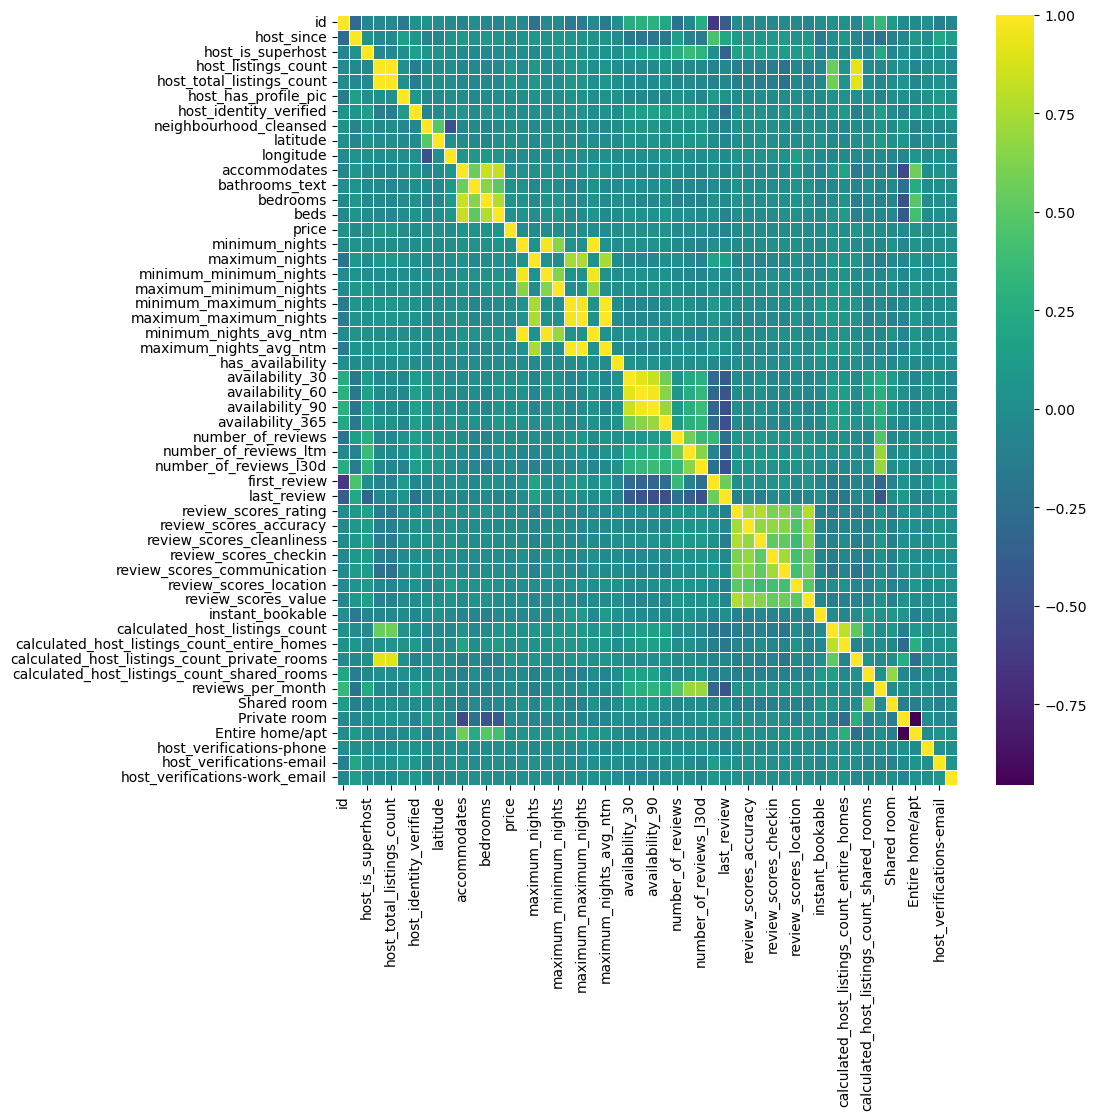

In [54]:
# Get a correlation matrix
fig = plt.figure(figsize= (10,10))
sns.heatmap(listings.corr(), vmax=1, cmap='viridis', square=False, annot=False, linewidth=.5)

In [103]:
listings2 = listings

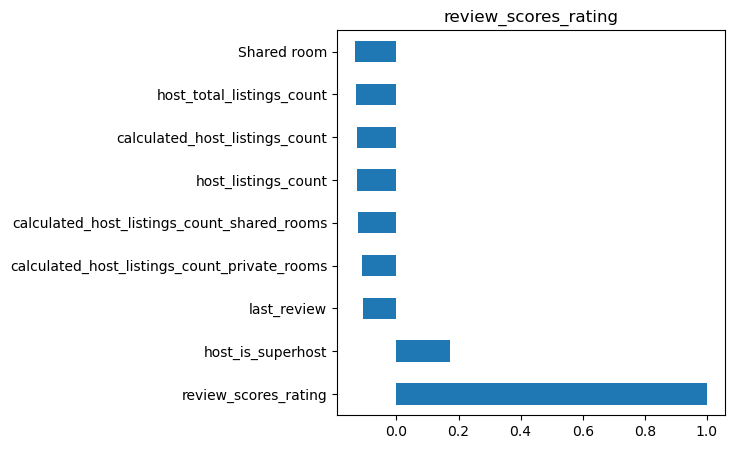

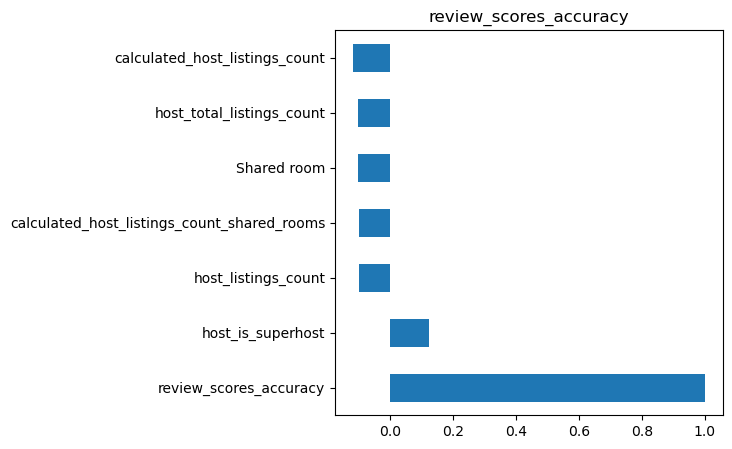

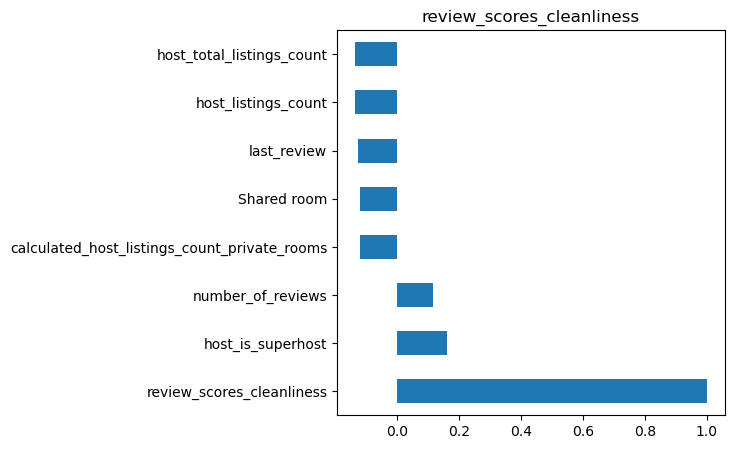

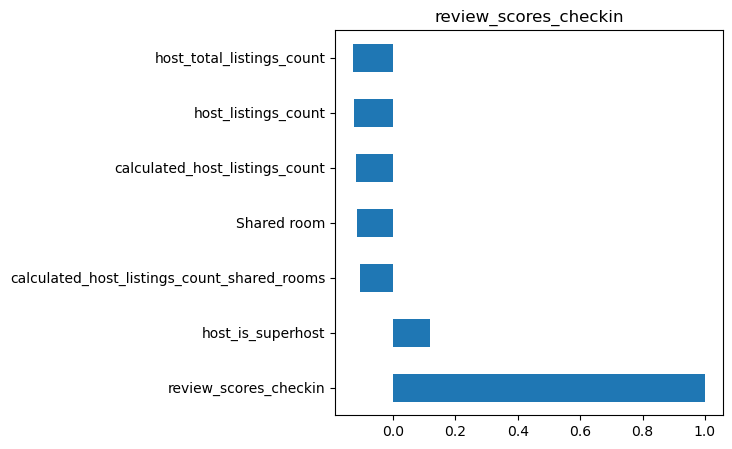

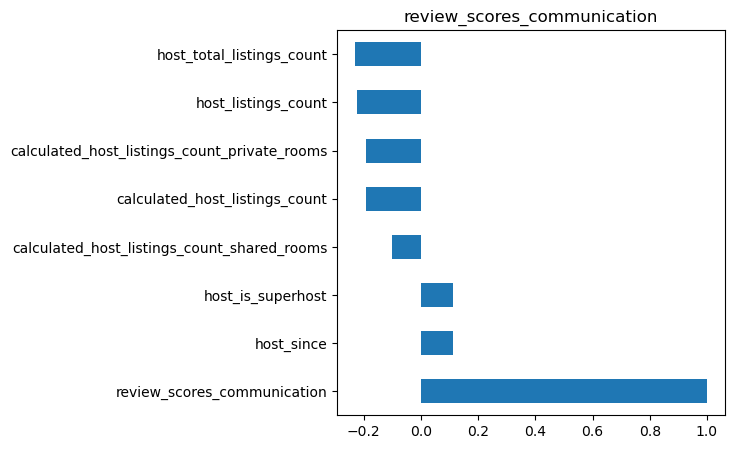

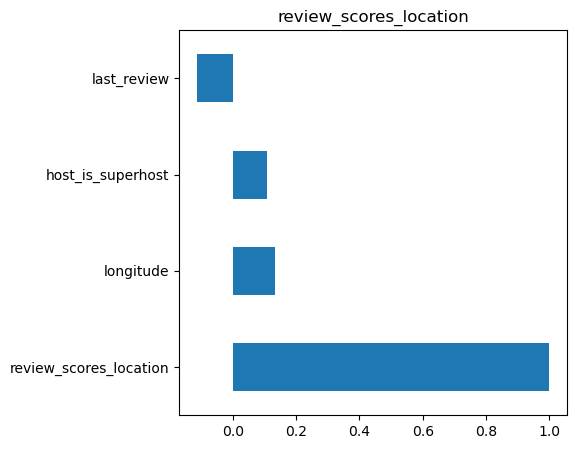

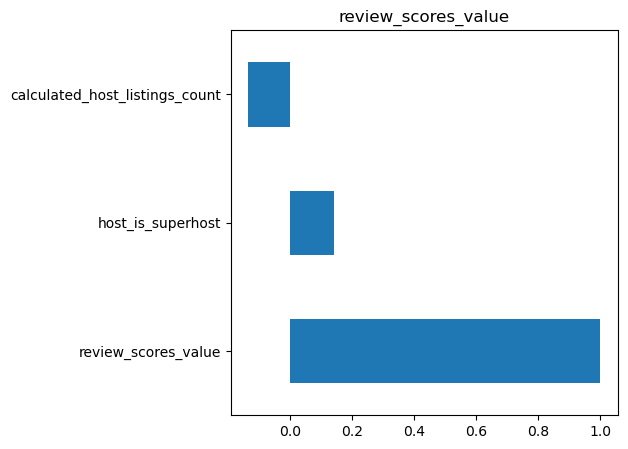

In [104]:
# correlation with the scores
scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
         'review_scores_communication', 'review_scores_location', 'review_scores_value']
# remove object columns
listings2 = listings2.drop(["description"], axis=1)
listings2 = listings2.drop(["amenities"], axis=1)
list_feature = {}
for score in scores:
    list_feature[score] = listings2
    for i in scores:
        if score != i:
            list_feature[score] = list_feature[score].drop([i], axis=1)
            
    corr = list_feature[score].corr()
    # get the features correlating with the scores
    corr_y = corr[score]    
    # Plot the features with > 0.1 correlation 
    fontsize = 10
    plt.figure(figsize=(5,5))
    corr_y[np.abs(corr_y) > 0.1].sort_values(ascending=False).plot.barh(title = score)
    # only features > 0.1 correlation would be left
    list_feature[score] = list_feature[score][corr_y[np.abs(corr_y) > 0.1].index.values]
    list_feature[score] = list_feature[score].drop([score], axis=1)

In [201]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor

# create dataset
X = {}
y = {}
for score in scores:
    X[score] = np.column_stack((np.array(list_feature[score]), d_comments))
    # standardization
    X[score] = (X[score] - np.mean(X[score], axis=0))/np.std(X[score], axis=0)
    y[score] = np.array(listings[score].tolist())

# baseline model
baseline = DummyRegressor(strategy='mean')
base_score = {}
base_std = {}
for score in scores:
    xtrain, xtest, ytrain, ytest = train_test_split(X[score], y[score], test_size=0.2)
    nMSE_score = cross_val_score(baseline,  xtrain, ytrain, cv=5, scoring="neg_mean_squared_error")
    base_score[score] = np.array(nMSE_score).mean()
    base_std[score] = np.array(nMSE_score).std()
    print(score)
    print("nMSE mean: ", np.array(nMSE_score).mean())
    print("nMSE std: ", np.array(nMSE_score).std())

review_scores_rating
nMSE mean:  -0.18169775867810062
nMSE std:  0.01102878475312016
review_scores_accuracy
nMSE mean:  -0.16103121798475487
nMSE std:  0.02511121850021636
review_scores_cleanliness
nMSE mean:  -0.2822255184034299
nMSE std:  0.017645526730260024
review_scores_checkin
nMSE mean:  -0.13647055590073962
nMSE std:  0.02439671527144247
review_scores_communication
nMSE mean:  -0.1186178085887813
nMSE std:  0.022524102554641504
review_scores_location
nMSE mean:  -0.12405308696869857
nMSE std:  0.02587163734564457
review_scores_value
nMSE mean:  -0.18973729635683317
nMSE std:  0.01430468814371582


best_nMSE: -0.16791011377968554
best_std: 0.026288890177706407


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.074e+01, tolerance: 6.811e-02
  model = cd_fast.enet_coordinate_descent(


best_nMSE: -0.15793878507134257
best_std: 0.03415514332769725
best_nMSE: -0.25420552828642484
best_std: 0.017752662959817138


/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.468e-01, tolerance: 4.929e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.750e+00, tolerance: 4.838e-02
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

best_nMSE: -0.12120200375523997
best_std: 0.013219608652819292
best_nMSE: -0.11200685267552565
best_std: 0.007436649143324015
best_nMSE: -0.11951813135097936
best_std: 0.011848434820031556
best_nMSE: -0.1836718250149745
best_std: 0.01840332670766681


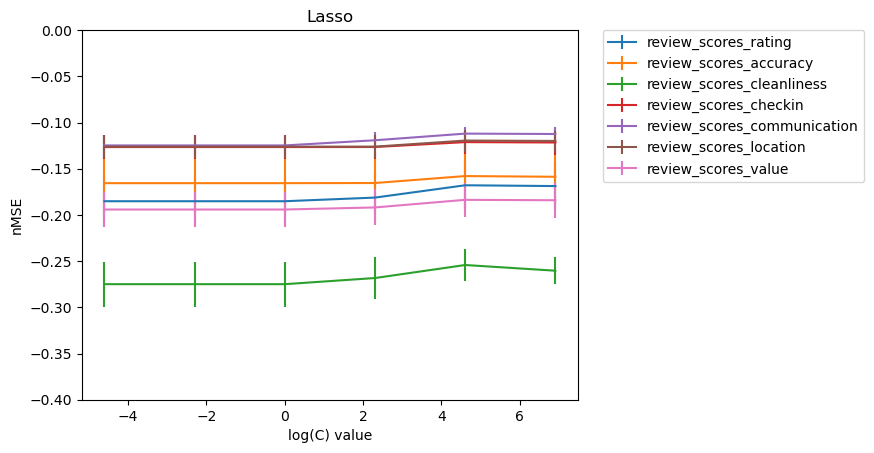

In [202]:
# train Lasso model
C = [0.01, 0.1, 1, 10, 100, 1000]
lasso_score = {}
lasso_std = {}
best_lasso_score = {}
best_lasso_std = {}
for score in scores:
    # find the best weight C
    nMSE_scores = []; std_error = []
    xtrain, xtest, ytrain, ytest = train_test_split(X[score], y[score], test_size=0.2)
    for i in C:
        # define model
        model = Lasso(alpha=1/(2*i))
        nMSE_score = cross_val_score(model,  xtrain, ytrain, cv=5, scoring="neg_mean_squared_error")
        nMSE_scores.append(np.array(nMSE_score).mean())
        std_error.append(np.array(nMSE_score).std())
    # save the best nMSE score
    best_lasso_score[score] = max(nMSE_scores)
    best_index = np.where(nMSE_scores == best_lasso_score[score])[0][0]
    best_lasso_std[score] = std_error[best_index]
    print("best_nMSE:", best_lasso_score[score])
    print("best_std:", best_lasso_std[score])
    lasso_score[score] = nMSE_scores
    lasso_std[score] = std_error
    
    plt.errorbar(np.log(C), lasso_score[score], yerr=lasso_std[score], label = score)
    
plt.xlabel('log(C) value')
plt.ylabel('nMSE') 
plt.title("Lasso")
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.ylim(-0.4, 0)
plt.show()

best_nMSE: -0.1676080069384245
best_std: 0.01860902725930716
best_nMSE: -0.16116977391829973
best_std: 0.02455244932407346
best_nMSE: -0.26789681240962904
best_std: 0.018300472788877326
best_nMSE: -0.1297644264314358
best_std: 0.03240397379272147
best_nMSE: -0.11705600456781384
best_std: 0.023648824383326182
best_nMSE: -0.11210232156334632
best_std: 0.013362568338261618
best_nMSE: -0.1846580773791308
best_std: 0.024853662235706845


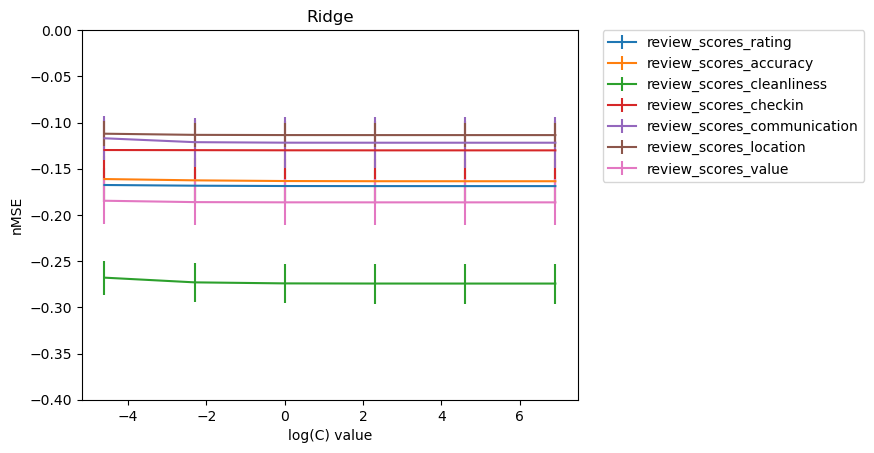

In [203]:
# train Ridge model
C = [0.01, 0.1, 1, 10, 100, 1000]
ridge_score = {}
ridge_std = {}
best_ridge_score = {}
best_ridge_std = {}
for score in scores:
    # find the best weight C
    nMSE_scores = []; std_error = []
    xtrain, xtest, ytrain, ytest = train_test_split(X[score], y[score], test_size=0.2)
    for i in C:
        # define model
        model = Ridge(alpha=1/(2*i))
        nMSE_score = cross_val_score(model,  xtrain, ytrain, cv=5, scoring="neg_mean_squared_error")
        nMSE_scores.append(np.array(nMSE_score).mean())
        std_error.append(np.array(nMSE_score).std())
    # save the best nMSE score
    best_ridge_score[score] = max(nMSE_scores)
    best_index = np.where(nMSE_scores == best_ridge_score[score])[0][0]
    best_ridge_std[score] = std_error[best_index]
    print("best_nMSE:", best_ridge_score[score])
    print("best_std:", best_ridge_std[score])
    ridge_score[score] = nMSE_scores
    ridge_std[score] = std_error
    
    plt.errorbar(np.log(C), ridge_score[score], yerr=ridge_std[score], label = score)
    
plt.xlabel('log(C) value')
plt.ylabel('nMSE') 
plt.title("Ridge")
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
plt.ylim(-0.4, 0)
plt.show()

In [198]:
import xgboost as xgb
# XGBoot model
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_score = {}
xgb_std = {}

for score in scores:
    xtrain, xtest, ytrain, ytest = train_test_split(X[score], y[score], test_size=0.2)
    nMSE_score = cross_val_score(xgb_model,  xtrain, ytrain, cv=5, scoring="neg_mean_squared_error")
    xgb_score[score] = np.array(nMSE_score).mean()
    xgb_std[score] = np.array(nMSE_score).std()
    print(score)
    print("nMSE mean: ", np.array(nMSE_score).mean())
    print("nMSE std: ", np.array(nMSE_score).std())


review_scores_rating
nMSE mean:  -0.13884025058040006
nMSE std:  0.017439878211681727
review_scores_accuracy
nMSE mean:  -0.16255391938260616
nMSE std:  0.03204060649366139
review_scores_cleanliness
nMSE mean:  -0.23548529636833568
nMSE std:  0.03704149705898379
review_scores_checkin
nMSE mean:  -0.13137913948411828
nMSE std:  0.021906492575723115
review_scores_communication
nMSE mean:  -0.10831153689075615
nMSE std:  0.015037521688890302
review_scores_location
nMSE mean:  -0.11560289890986189
nMSE std:  0.01735427634146745
review_scores_value
nMSE mean:  -0.16262618185430291
nMSE std:  0.020652863170240753


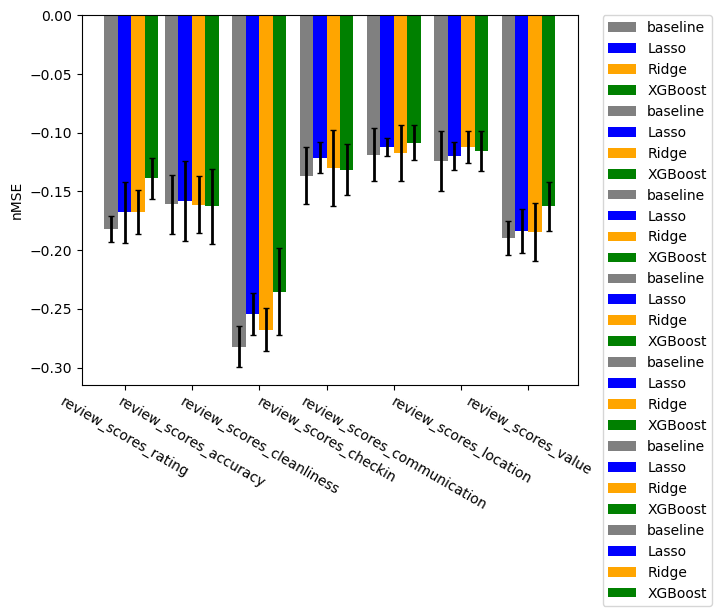

In [204]:
err_attr={"elinewidth":2,"ecolor":"black","capsize":2}
total_width, n = 0.6, 3 
width = total_width / n 
#x = [0, 1, 2, 3, 4, 5, 6, 7]
x = [-0.2, 0.7, 1.7, 2.7, 3.7, 4.7, 5.7, 6.7]
i = 0
for score in scores:
    plt.bar(x[i], base_score[score], yerr=base_std[score], error_kw=err_attr,width = width, label="baseline", fc="gray")
    x[i] = x[i] + width
    plt.bar(x[i], best_lasso_score[score], yerr=best_lasso_std[score], error_kw=err_attr,width = width, label="Lasso", fc="blue")
    x[i] = x[i] + width
    plt.bar(x[i], best_ridge_score[score], yerr=best_ridge_std[score], error_kw=err_attr,width = width, label="Ridge", fc="orange")
    x[i] = x[i] + width
    plt.bar(x[i], xgb_score[score], yerr=xgb_std[score], error_kw=err_attr,width = width, label="XGBoost", fc="green")
    x[i] = x[i] + width
    i += 1
plt.xticks(range(0,7), labels=scores, rotation=330)
plt.ylabel('nMSE')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0)
plt.show()


